##### **Imports**

In [107]:
# Maths and data manipulation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# For the neural network (PyTorch)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim

# Implementing neural network model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


##### **Observing the Data**

In [108]:
df = pd.read_excel("/Users/isacfiorotti/repo/msc/COMP4139/CW2/TrainDataset2023.xls")
df.head()

,ID,pCR (outcome),RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,TRG002174,1,144.0,41.0,0,0,0,1,3,3,...,0.517172,0.375126,3.325332,0.002314,3880771.500,473.464852,0.000768,0.182615,0.030508,0.000758
1,TRG002178,0,142.0,39.0,1,1,0,0,3,3,...,0.444391,0.444391,3.032144,0.005612,2372009.744,59.459710,0.004383,0.032012,0.001006,0.003685
2,TRG002204,1,135.0,31.0,0,0,0,1,2,1,...,0.534549,0.534549,2.485848,0.006752,1540027.421,33.935384,0.007584,0.024062,0.000529,0.006447
3,TRG002206,0,12.0,35.0,0,0,0,1,3,3,...,0.506185,0.506185,2.606255,0.003755,6936740.794,46.859265,0.005424,0.013707,0.000178,0.004543
4,TRG002210,0,109.0,61.0,1,0,0,0,2,1,...,0.462282,0.462282,2.809279,0.006521,1265399.054,39.621023,0.006585,0.034148,0.001083,0.005626


[  1   0 999]


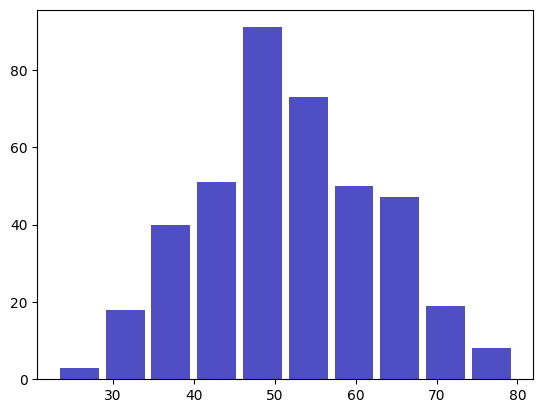

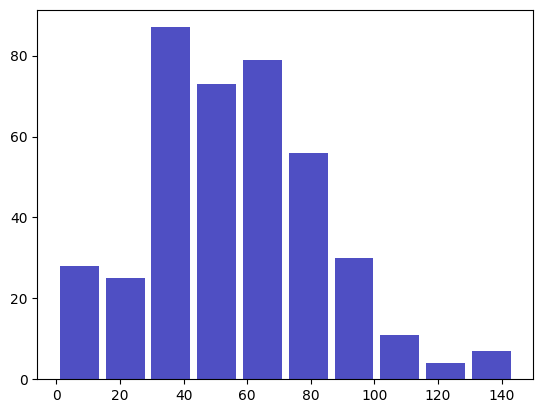

In [109]:
# Display the range of the age range in graph
df['Age'].unique()

# Using matplotlib to plot the graph of age range
plt.hist(df['Age'], bins=10, color='#0504aa', alpha=0.7, rwidth=0.85)

""" 
Observation, the model does not have many datapoints at the extremities of the dataset
it will not perform well at performing classifications at those ranges
"""

# Using matplotlib to plot the graph of RelapseFreeSurvival range
plt.figure()
plt.hist(df['RelapseFreeSurvival (outcome)'], bins=10, color='#0504aa', alpha=0.7, rwidth=0.85)

# Check for presence of outliers in classification 
print(df['pCR (outcome)'].unique())

In [110]:
df.drop(df.columns[:13], axis=1, inplace=True)

' Observation, there are multiple outliers in the dataset,\n    possible suggestions for fixing this is to remove the outliers\n    alternatively, change the outliers to the mean of the dataset\n\n    In the data most features have approximately 1-4% outliers, however there are some features\n    which have approximately 10% outliers, this could be due to the feature not following a normal distribution?\n'

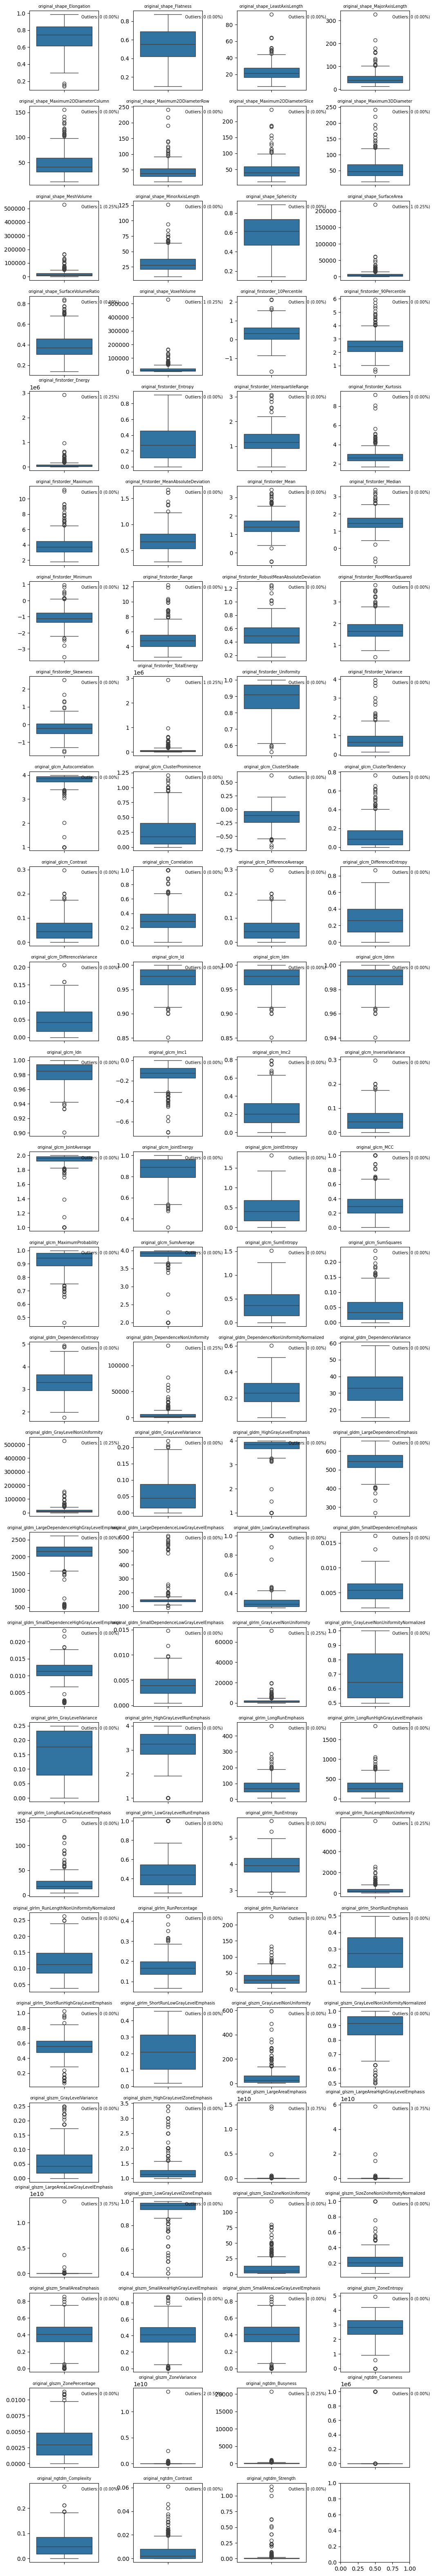

In [111]:
# Box plot of each feature seperately, small and next to each other using seaborn
cols = len(df.columns)
rows = int(np.ceil(cols / 4.0))

# Set the width and height of each individual subplot
subplot_width = 3
subplot_height = 3

# Calculate the total figure size
fig_width = 4 * subplot_width
fig_height = rows * subplot_height

fig, axes = plt.subplots(nrows=rows, ncols=4, figsize=(fig_width, fig_height))
fig.subplots_adjust(hspace =.2, wspace=.5)
axes = axes.ravel()
for i, column in enumerate(df.columns):
    sns.boxplot(y=column, data=df, ax=axes[i])
    axes[i].set_title(column, fontsize=7)
    axes[i].set_ylabel('')

    # Label next to boxplot showing total number of outliers and percentage of outliers using IQR
    outliers = df[column]
    q1 = outliers.quantile(0.01)
    q3 = outliers.quantile(0.99)
    iqr = q3 - q1
    lower = q1 - (1.5 * iqr)
    upper = q3 + (1.5 * iqr)
    bound1 = 1
    bound2 = 75

    # Calculate the number of outliers outside the 1 and 99 percentile
    outliers = outliers[(outliers < lower) | (outliers > upper)]
    outliers_count = len(outliers)
    outliers_percent = outliers_count / len(df[column]) * 100
    axes[i].text(0.75, 0.95, f'Outliers: {outliers_count} ({outliers_percent:.2f}%)', transform=axes[i].transAxes, fontsize=7, verticalalignment='top')




    
    
""" Observation, there are multiple outliers in the dataset,
    possible suggestions for fixing this is to remove the outliers
    alternatively, change the outliers to the mean of the dataset

    In the data most features have approximately 1-4% outliers, however there are some features
    which have approximately 10% outliers, this could be due to the feature not following a normal distribution?
"""

##### **Cleaning Data**

In [112]:
# Removing the 0.5% and the 99.5% percentile in data
for column in df.columns:
    percentile_1 = df[column].quantile(0.05)
    percentile_90 = df[column].quantile(0.90)
    df[column] = df[column].clip(percentile_1, percentile_90)

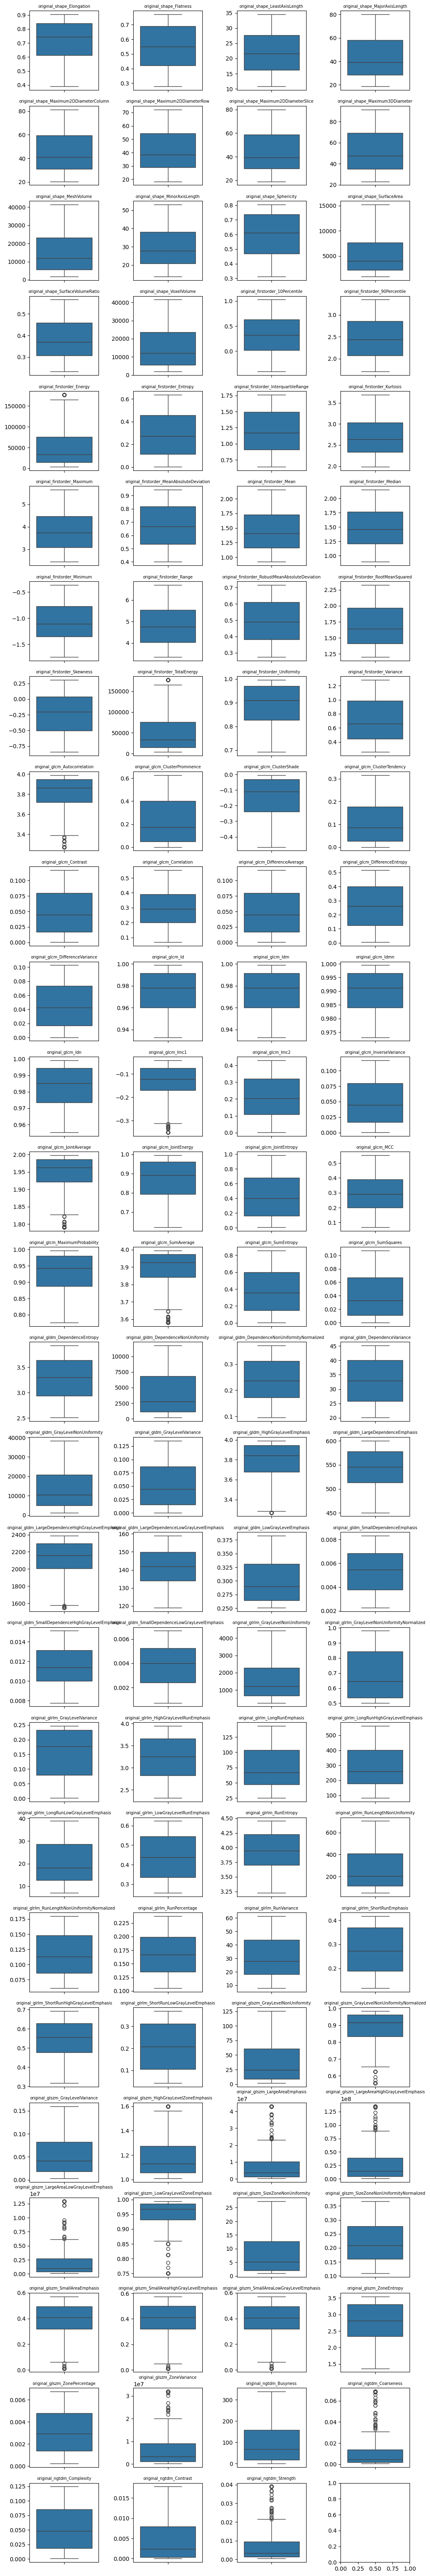

In [113]:

# Box plot of each feature seperately, small and next to each other using seaborn
cols = len(df.columns)
rows = int(np.ceil(cols / 4.0))

# Set the width and height of each individual subplot
subplot_width = 3
subplot_height = 3

# Calculate the total figure size
fig_width = 4 * subplot_width
fig_height = rows * subplot_height

fig, axes = plt.subplots(nrows=rows, ncols=4, figsize=(fig_width, fig_height))
fig.subplots_adjust(hspace =.2, wspace=.5)
axes = axes.ravel()
for i, column in enumerate(df.columns):
    sns.boxplot(y=column, data=df, ax=axes[i])
    axes[i].set_title(column, fontsize=7)
    axes[i].set_ylabel('')
    
# Consider data imputation

# Consider working with the rest of the data that is missing beyond the features

##### **Dimensionality Reduction**

In [114]:
# Normalise the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

Text(0, 0.5, 'Variance Explained')

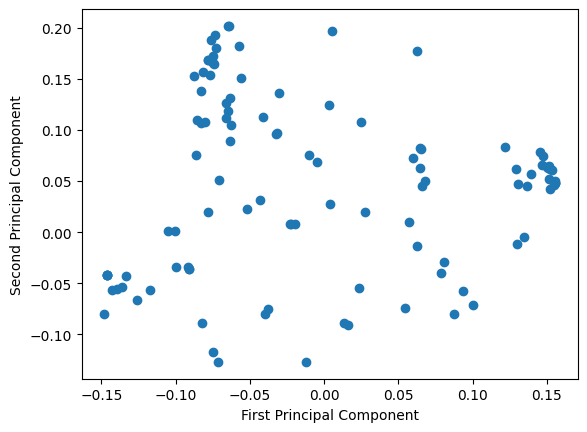

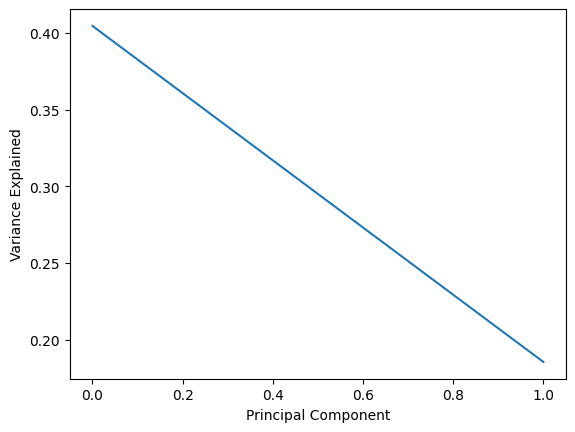

In [115]:
# Apply PCA to the data
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit_transform(df)

# Plot the PCA components
plt.figure()
plt.scatter(pca.components_[0], pca.components_[1])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

# Scree plot
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')


##### **Standard Implementation of Neural Network for Classification**

In [116]:
df_all = pd.read_excel("/Users/isacfiorotti/repo/msc/COMP4139/CW2/TrainDataset2023.xls")
df_all.drop(df_all.columns[:1], axis=1, inplace=True)  # Remove the ID

# TODO Change where this is called to somewhere in the data cleaning process
# Remove rows which have pCR (outcome) as 999
df_all = df_all[df_all['pCR (outcome)'] != 999]

# Split the dataset into training and testing data
X = df_all.drop('pCR (outcome)', axis=1)
y = df_all['pCR (outcome)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Text(0.5, 0, 'Epoch')

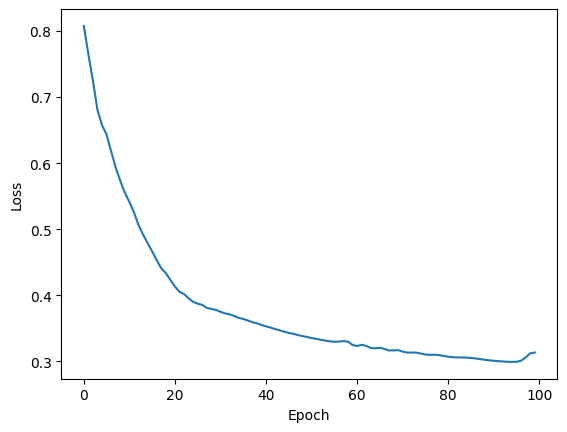

In [117]:
# Convert the data into tensors
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(y_train.values)
y_test_tensor = torch.LongTensor(y_test.values)

# Get the number of input features
input_features = X_train.shape[1]

# Create the model
# TODO: Experiment with different number of hidden layers and hidden units
class ANN(nn.Module):
    def __init__(self, input_features, hidden1=12, out_features=2):
        super().__init__()
        self.f_connected1 = nn.Linear(input_features, hidden1)
        self.out = nn.Linear(hidden1, out_features)

    def forward(self, x):
        x = self.f_connected1(x)
        x = self.out(x)
        return x
    
# Instantiate the model
model = ANN(input_features)

# Move the model and data to the CPU
device = torch.device('mps')
model.to(device)
X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# TODO: Define the loss function and the optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
epochs = 100
losses = []

# TODO: Add validation set

# TODO: Add early stopping
# TODO: Add model checkpointing
# TODO: Add learning rate scheduler
# TODO: Add model saving
# TODO: Add model loading
# TODO: Add model evaluation
# TODO: Add model prediction
# TODO: Add model inference  

for i in range(epochs):
    y_pred = model.forward(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    losses.append(loss.item())
    
    # Zero the gradients
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()
    
    # Update the weights
    optimizer.step()

# Plot the loss
plt.figure()
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')

# TODO: Evaluate the model




##### **Standard Implementation of Neural Network for Regression**

In [118]:
df_all = pd.read_excel("./TrainDataset2023.xls")
df_all.drop(df_all.columns[:1], axis=1, inplace=True)  # Remove the ID column

# Remove rows which have pCR (outcome) as 999
df_all = df_all[df_all['pCR (outcome)'] != 999]

# Split the dataset into training and testing data
X = df_all.drop('pCR (outcome)', axis=1)
y = df_all['pCR (outcome)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)